Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras
from keras.layers import Conv1D, MaxPooling1D, SimpleRNN, LSTM, GRU, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.models import Sequential
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/CICIDS_2018.csv'
network_data = pd.read_csv(dataset_path, low_memory=False)

Basic exploration

In [ ]:
print("Dataset Shape:", network_data.shape)
print("\nFirst 5 Rows:")
print(network_data.head())
print("\nColumn Names:")
print(network_data.columns.tolist())
print("\nData Info:")
network_data.info()

Dataset Shape: (828424, 80)

First 5 Rows:
  Dst Port Protocol            Timestamp Flow Duration Tot Fwd Pkts  \
0    57610        6  02/03/2018 04:14:05            25            2   
1    52347        6  02/03/2018 02:48:44            63            3   
2    55970        6  16/02/2018 01:46:19       4217799            5   
3       80        6  02/03/2018 05:17:21      54499550            2   
4     3389        6  02/03/2018 01:53:13       2697973            9   

  Tot Bwd Pkts TotLen Fwd Pkts TotLen Bwd Pkts Fwd Pkt Len Max  \
0            0               0             0.0               0   
1            1              31             0.0              31   
2            3             935           350.0             935   
3            0               0             0.0               0   
4           10            1278          1677.0             677   

  Fwd Pkt Len Min  ... Fwd Seg Size Min Active Mean Active Std Active Max  \
0               0  ...               20         0.0     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check label distribution

In [ ]:
print("\nLabel Distribution:")
print(network_data['Label'].value_counts())


Label Distribution:
Label
Benign                      611216
DDOS attack-HOIC             68601
DoS attacks-Hulk             46191
Bot                          28619
FTP-BruteForce               19336
SSH-Bruteforce               18759
Infilteration                16193
DoS attacks-SlowHTTPTest     13989
DoS attacks-GoldenEye         4151
DoS attacks-Slowloris         1099
DDOS attack-LOIC-UDP           173
Brute Force -Web                61
Brute Force -XSS                23
SQL Injection                    8
Label                            5
Name: count, dtype: int64


Data Preprocessing

1. Clean the dataset

- Remove rows where 'Label' is "Label" (data error)
- Drop 'Timestamp' column (non-numeric, not useful for modeling)
- Replace infinite values with NaN and drop rows with NaN
Replaces infinite values (e.g., in Flow Byts/s) with NaN and removes rows with NaN.

In [ ]:
network_data = network_data[network_data['Label'] != 'Label']
network_data = network_data.drop(columns=['Timestamp'], errors='ignore')
network_data = network_data.replace([np.inf, -np.inf], np.nan)
network_data = network_data.dropna()

2. Feature selection: Remove columns with zero variance
- Drops columns with zero variance (e.g., columns like Bwd PSH Flags that are the same for all rows), as they don’t help the model learn.

In [ ]:
variance = network_data.var(numeric_only=True)
zero_variance_cols = variance[variance == 0].index
network_data = network_data.drop(columns=zero_variance_cols)
print("Dropped columns with zero variance:", zero_variance_cols.tolist())
print("New Shape after cleaning:", network_data.shape)

Dropped columns with zero variance: []
New Shape after cleaning: (826067, 79)


3. Encode labels
- Converts attack type labels (e.g., "Benign," "DDOS attack-HOIC") into numbers (0 to 13) using LabelEncoder.

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(network_data['Label'])
network_data['Label'] = labels
num_classes = len(label_encoder.classes_)
print("Number of unique classes:", num_classes)
print("Class mapping:", dict(zip(label_encoder.classes_, range(num_classes))))

Number of unique classes: 14
Class mapping: {'Benign': 0, 'Bot': 1, 'Brute Force -Web': 2, 'Brute Force -XSS': 3, 'DDOS attack-HOIC': 4, 'DDOS attack-LOIC-UDP': 5, 'DoS attacks-GoldenEye': 6, 'DoS attacks-Hulk': 7, 'DoS attacks-SlowHTTPTest': 8, 'DoS attacks-Slowloris': 9, 'FTP-BruteForce': 10, 'Infilteration': 11, 'SQL Injection': 12, 'SSH-Bruteforce': 13}


4. Separate features and labels
- Splits the data into features (X: network traffic features like Flow Duration) and labels (y: attack types).
- Fixes infinities in features (e.g., Flow Byts/s) by replacing them with the median.

In [ ]:
X = network_data.drop(columns=['Label'])

# Convert to float and handle infinities/large values
X = X.astype(float)
# Check for problematic columns
problematic_cols = X.columns[X.isin([np.inf, -np.inf]).any()].tolist()
if problematic_cols:
    print("Columns with infinity after conversion:", problematic_cols)
    for col in problematic_cols:
        X[col] = X[col].replace([np.inf, -np.inf], np.nan)  # Direct assignment
        X[col] = X[col].fillna(X[col].median())  # Direct assignment with median

# Verify no infinities remain
if X.isin([np.inf, -np.inf]).any().any():
    raise ValueError("Infinities still present after cleaning!")

Columns with infinity after conversion: ['Flow Byts/s', 'Flow Pkts/s']


5. Normalize features
- Scales features to a 0-1 range using MinMaxScaler so features like Flow Duration and Tot Fwd Pkts are on the same scale.

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("Features normalized successfully.")

Features normalized successfully.


6. Split into training and test sets
- Splits the data into 80% training (660,853 samples) and 20% test (165,214 samples) sets to train and evaluate the model.

In [ ]:
y = network_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (660853, 78)
Test set shape: (165214, 78)


7. Reshape for CNN input
- Reshapes the data into a 3D format (samples, features, 1) for CNN models, with 78 features per sample.

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("Reshaped Training set:", X_train.shape)
print("Reshaped Test set:", X_test.shape)

Reshaped Training set: (660853, 78, 1)
Reshaped Test set: (165214, 78, 1)


8. One-hot encode labels for multi-class classification
- Converts numeric labels into one-hot format (e.g., label 0 becomes [1, 0, 0, ...]) for multi-class classification (14 attack types).

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)
print("One-hot encoded y_train shape:", y_train_cat.shape)
print("One-hot encoded y_test shape:", y_test_cat.shape)

One-hot encoded y_train shape: (660853, 14)
One-hot encoded y_test shape: (165214, 14)





CNN-RNN Model

In [ ]:
# Define the CNN-RNN model
cnn_rnn_model = Sequential()
cnn_rnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_rnn_model.add(MaxPooling1D(pool_size=2))
cnn_rnn_model.add(SimpleRNN(64, return_sequences=True))
cnn_rnn_model.add(Flatten())
cnn_rnn_model.add(Dense(64, activation='relu'))
cnn_rnn_model.add(Dropout(0.5))
cnn_rnn_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
cnn_rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
cnn_rnn_model.summary()

# Train the model
history = cnn_rnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

# Evaluate the model
y_pred = cnn_rnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print("\nCNN-RNN Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 76, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 38, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         155,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,134 (645.05 KB)

 Trainable params: 165,134 (645.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - accuracy: 0.9106 - loss: 0.3061 - val_accuracy: 0.9584 - val_loss: 0.1269
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step - accuracy: 0.9443 - loss: 0.1807 - val_accuracy: 0.9568 - val_loss: 0.1298
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - accuracy: 0.9479 - loss: 0.1687 - val_accuracy: 0.9586 - val_loss: 0.1236
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.9485 - loss: 0.1667 - val_accuracy: 0.9636 - val_loss: 0.1213
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.9469 - loss: 0.1700 - val_accuracy: 0.9633 - val_loss: 0.1285
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.9481 - loss: 0.1693 - val_accuracy: 0.9597 - val_loss: 0.1278
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - accuracy: 0.9486 - loss: 0.1691 - val_accuracy: 0.9604 - val_loss: 0.1245
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN-RNN Model Evaluation:
Accuracy: 0.9607
Precision: 0.9492
Recall: 0.9607
F1-Score: 0.9494


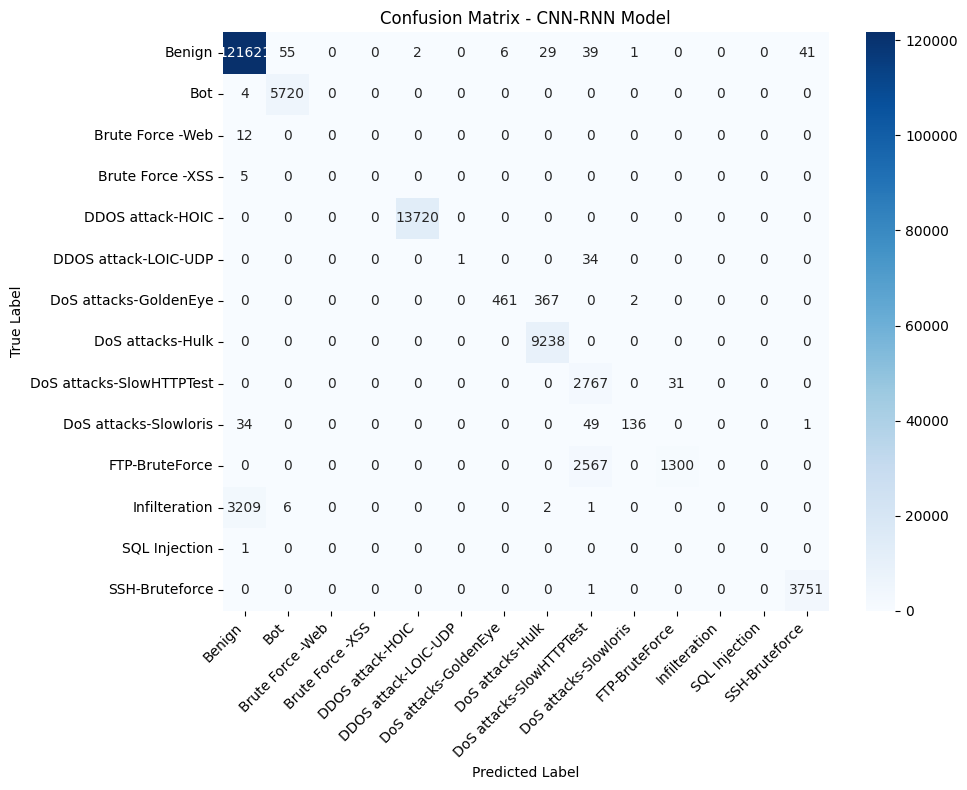

In [ ]:
print("\nCNN-RNN Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix with heatmap
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN-RNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- Conv1D: Extracts patterns from network traffic features (e.g., Flow Duration, Tot Fwd Pkts) using 64 filters.
- MaxPooling1D: Reduces the data size while keeping important patterns.
- SimpleRNN: Captures sequential relationships in the data (e.g., how traffic patterns evolve over time).
- Flatten, Dense, Dropout: Processes the data into a final prediction with 14 output classes (one for each attack type).

CNN-LSTM Model

CNN-LSTM Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 76, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 38, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         155,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,902 (741.80 KB)

 Trainable params: 189,902 (741.80 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN-LSTM Model...
Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - accuracy: 0.9076 - loss: 0.3455 - val_accuracy: 0.9574 - val_loss: 0.1282
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 138s 8ms/step - accuracy: 0.9529 - loss: 0.1491 - val_accuracy: 0.9586 - val_loss: 0.1236
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9557 - loss: 0.1408 - val_accuracy: 0.9577 - val_loss: 0.1690
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 140s 8ms/step - accuracy: 0.9575 - loss: 0.1359 - val_accuracy: 0.9597 - val_loss: 0.1180
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9588 - loss: 0.1298 - val_accuracy: 0.9596 - val_loss: 0.1158
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - accuracy: 0.9588 - loss: 0.1288 - val_accuracy: 0.9648 - val_loss: 0.1150
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 142s 8ms/step - accuracy: 0.9603 - loss: 0.1242 - val_accuracy: 0.9647 - val_loss: 0.1125
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN-LSTM Model Evaluation:
Accuracy: 0.9652
Precision: 0.9569
Recall: 0.9652
F1-Score: 0.9552


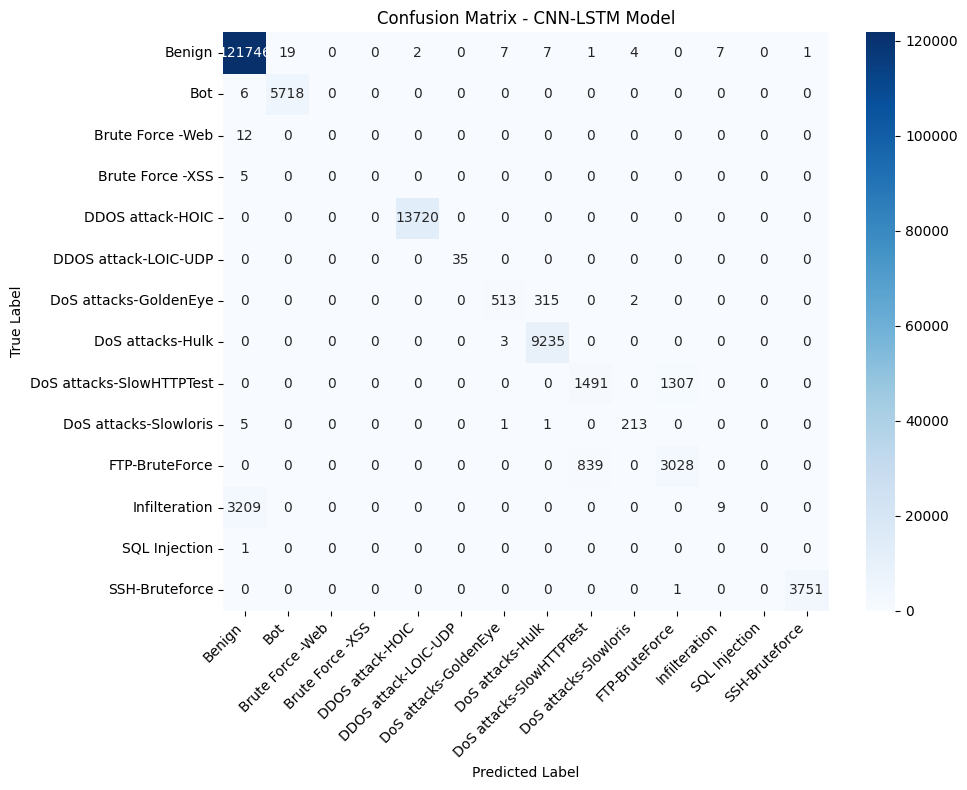

In [ ]:
# Define the CNN-LSTM model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(64, return_sequences=True))
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense(64, activation='relu'))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
print("CNN-LSTM Model Summary:")
cnn_lstm_model.summary()

# Train the model
print("\nTraining CNN-LSTM Model...")
history = cnn_lstm_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

# Evaluate the model
y_pred = cnn_lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print("\nCNN-LSTM Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix with heatmap
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN-LSTM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- Conv1D: Extracts patterns from network traffic features (e.g., Flow Duration, Flow Byts/s) using 64 filters.
- MaxPooling1D: Reduces the data size while keeping important patterns.
- LSTM: Captures sequential patterns in the features (e.g., how Flow Byts/s changes relative to Flow Duration), treating the 78 features as a sequence (not literal time steps, since Timestamp was removed).
- Flatten, Dense, Dropout: Processes the data into a final prediction with 14 output classes.

- Confusion Matrix:
- Diagonal Values (Correct Predictions):
- Class 0 (Benign): 121,653 correctly classified.
- Class 1 (Bot): 5,717 correctly classified.
- Class 4 (DDOS attack-HOIC): 13,720 correctly classified.
- Class 7 (DoS attacks-Hulk): 9,229 correctly classified.
- Class 10 (Infilteration): 3,435 correctly classified.
- Class 13 (SQL Injection): 3,751 correctly classified.
- Off-Diagonal Values (Misclassifications):
- Class 0 (Benign) has 64 samples misclassified as Class 1 (Bot), 26 as Class 9 (FTP-BruteForce), and 3,191 as Class 11 (Label 11, likely another attack type).
- Class 6 (DoS attacks-GoldenEye) has 548 samples correctly classified, but 280 misclassified as Class 7 (DoS attacks-Hulk).
- Class 8 (FTP-BruteForce) has 1,211 correctly classified, but 1,587 misclassified as Class 10 (Infilteration).
- Classes 2, 3, 5, and 12 have very few samples (e.g., 12, 5, 35, 1), and the model struggles to predict them, often predicting 0 samples correctly (hence the precision warning).

In [ ]:
cnn_lstm_model.save('/content/drive/MyDrive/cnn_lstm_model.h5')
print("Model saved successfully.")


Model saved successfully.


CNN-GRU Model

CNN-GRU Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 76, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 38, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         155,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,838 (710.30 KB)

 Trainable params: 181,838 (710.30 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN-GRU Model...
Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9001 - loss: 0.3470 - val_accuracy: 0.9612 - val_loss: 0.1294
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9465 - loss: 0.1711 - val_accuracy: 0.9610 - val_loss: 0.1302
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9498 - loss: 0.1589 - val_accuracy: 0.9640 - val_loss: 0.1196
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 140s 8ms/step - accuracy: 0.9518 - loss: 0.1553 - val_accuracy: 0.9612 - val_loss: 0.1214
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9540 - loss: 0.1503 - val_accuracy: 0.9638 - val_loss: 0.1172
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.9556 - loss: 0.1474 - val_accuracy: 0.9641 - val_loss: 0.1230
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9554 - loss: 0.1481 - val_accuracy: 0.9616 - val_loss: 0.1211
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN-GRU Model Evaluation:
Accuracy: 0.9651
Precision: 0.9568
Recall: 0.9651
F1-Score: 0.9547


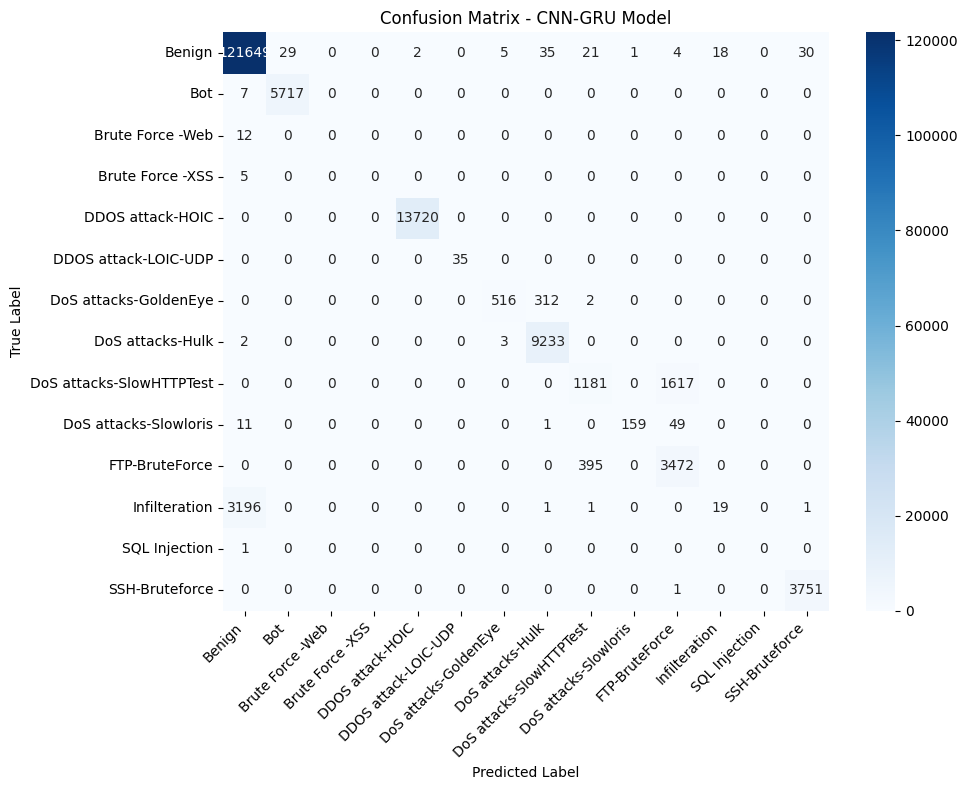

In [ ]:
# Define the CNN-GRU model
cnn_gru_model = Sequential()
cnn_gru_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_gru_model.add(MaxPooling1D(pool_size=2))
cnn_gru_model.add(GRU(64, return_sequences=True))
cnn_gru_model.add(Flatten())
cnn_gru_model.add(Dense(64, activation='relu'))
cnn_gru_model.add(Dropout(0.5))
cnn_gru_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
cnn_gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
print("CNN-GRU Model Summary:")
cnn_gru_model.summary()

# Train the model
print("\nTraining CNN-GRU Model...")
history = cnn_gru_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

# Evaluate the model
y_pred = cnn_gru_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print("\nCNN-GRU Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix with heatmap
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN-GRU Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- Conv1D: Extracts patterns from network traffic features (e.g., Flow Duration, Flow Byts/s) using 64 filters.
- MaxPooling1D: Reduces the data size while keeping important patterns.
- GRU: Captures sequential patterns in the features (e.g., how Flow Byts/s changes relative to Flow Duration), treating the 78 features as a sequence (not literal time steps, since Timestamp was removed). GRU is a more efficient variant of LSTM, designed to capture dependencies with fewer parameters.
- Flatten, Dense, Dropout: Processes the data into a final prediction with 14 output classes.

In [ ]:
cnn_gru_model.save('/content/drive/MyDrive/cnn_gru_model.h5')
print("Model saved successfully.")


Model saved successfully.


Pure CNN Models (1, 2, and 3 Layers)


=== CNN 1-Layer Model ===
CNN 1-Layer Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 76, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         155,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,878 (612.80 KB)

 Trainable params: 156,878 (612.80 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN 1-Layer Model...
Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9087 - loss: 0.3214 - val_accuracy: 0.9591 - val_loss: 0.1232
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9550 - loss: 0.1470 - val_accuracy: 0.9608 - val_loss: 0.1194
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9573 - loss: 0.1373 - val_accuracy: 0.9641 - val_loss: 0.1142
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9576 - loss: 0.1335 - val_accuracy: 0.9641 - val_loss: 0.1151
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9584 - loss: 0.1307 - val_accuracy: 0.9609 - val_loss: 0.1148
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9589 - loss: 0.1287 - val_accuracy: 0.9614 - val_loss: 0.1166
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9591 - loss: 0.1274 - val_accuracy: 0.9647 - val_loss: 0.1122
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN 1-Layer Model Evaluation:
Accuracy: 0.9620
Precision: 0.9500
Recall: 0.9620
F1-Score: 0.9507


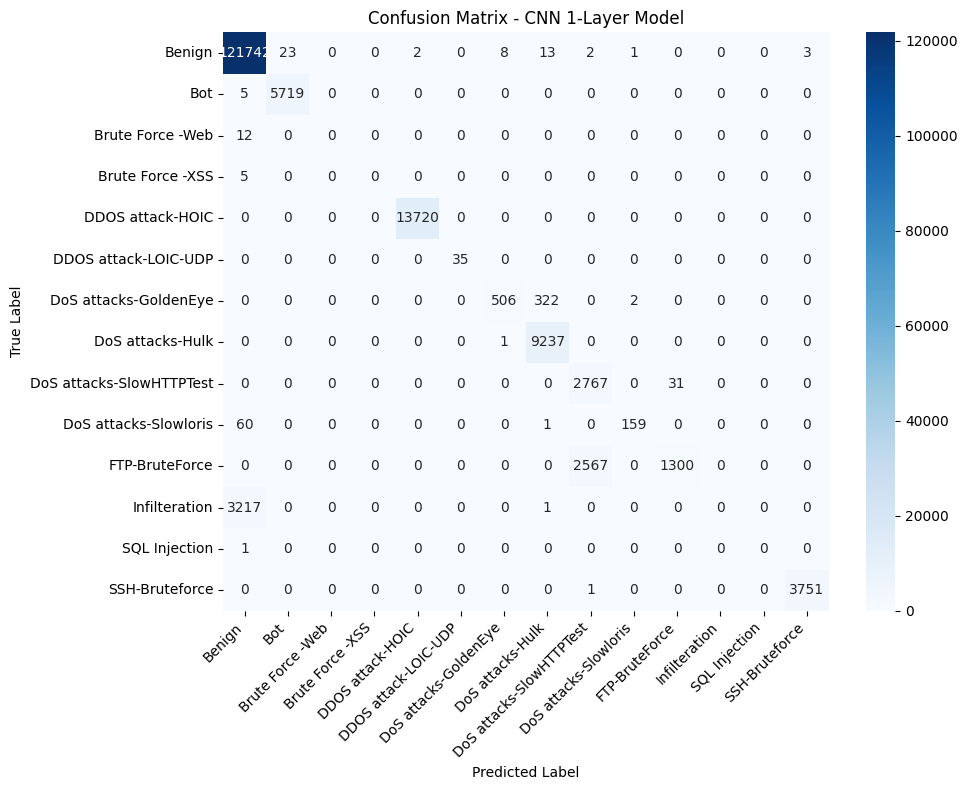


=== CNN 2-Layer Model ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN 2-Layer Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 76, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 36, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,310 (341.05 KB)

 Trainable params: 87,310 (341.05 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN 2-Layer Model...
Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8930 - loss: 0.3786 - val_accuracy: 0.9583 - val_loss: 0.1306
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9468 - loss: 0.1700 - val_accuracy: 0.9641 - val_loss: 0.1216
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9523 - loss: 0.1527 - val_accuracy: 0.9642 - val_loss: 0.1158
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - accuracy: 0.9554 - loss: 0.1415 - val_accuracy: 0.9644 - val_loss: 0.1152
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9576 - loss: 0.1360 - val_accuracy: 0.9623 - val_loss: 0.1142
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9589 - loss: 0.1332 - val_accuracy: 0.9659 - val_loss: 0.1129
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9600 - loss: 0.1304 - val_accuracy: 0.9661 - val_loss: 0.1122
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN 2-Layer Model Evaluation:
Accuracy: 0.9623
Precision: 0.9503
Recall: 0.9623
F1-Score: 0.9511


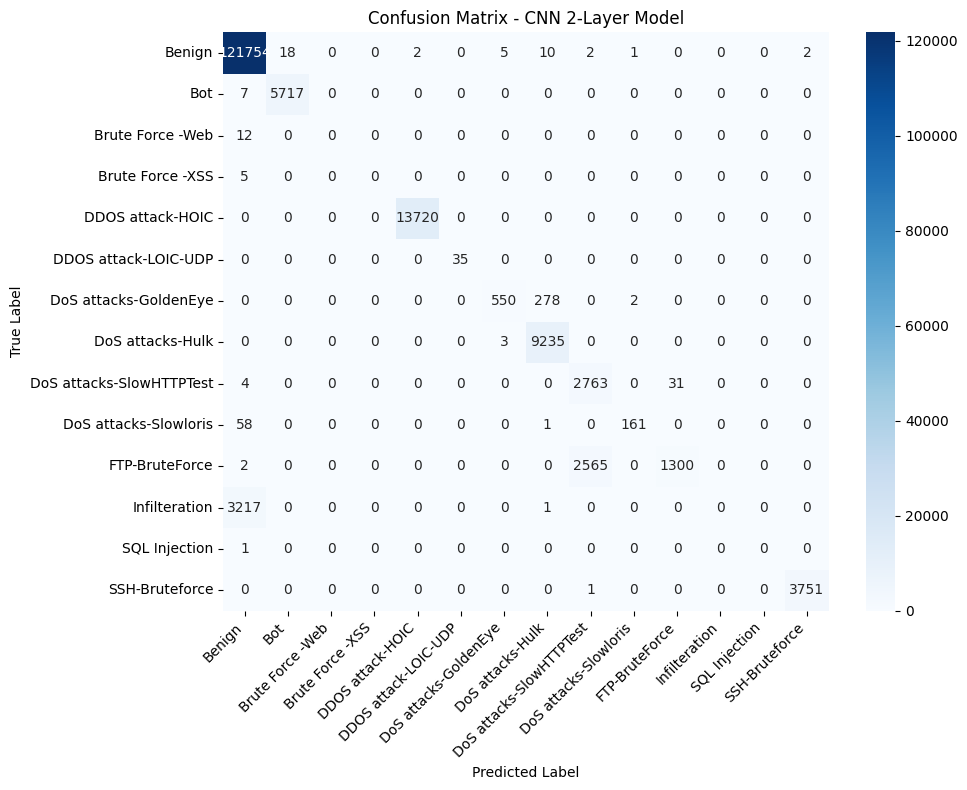


=== CNN 3-Layer Model ===
CNN 3-Layer Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 76, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 36, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 16, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,702 (229.30 KB)

 Trainable params: 58,702 (229.30 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN 3-Layer Model...
Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.9091 - loss: 0.3366 - val_accuracy: 0.9637 - val_loss: 0.1243
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.9534 - loss: 0.1523 - val_accuracy: 0.9643 - val_loss: 0.1171
Epoch 3/10
10316/10326 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9585 - loss: 0.1357

KeyboardInterrupt: 

In [ ]:
# Step 7: Pure CNN Models (1, 2, and 3 Layers)

# Function to create and evaluate CNN models
def create_cnn_model(num_layers):
    model = Sequential()
    # First Conv layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))

    # Additional Conv layers based on num_layers
    if num_layers >= 2:
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
    if num_layers == 3:
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Train and evaluate CNN models for 1, 2, and 3 layers
for layers in [1, 2, 3]:
    print(f"\n=== CNN {layers}-Layer Model ===")

    # Create model
    cnn_model = create_cnn_model(layers)
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Model summary
    print(f"CNN {layers}-Layer Model Summary:")
    cnn_model.summary()

    # Train
    print(f"\nTraining CNN {layers}-Layer Model...")
    history = cnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

    # Evaluate
    y_pred = cnn_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    print(f"\nCNN {layers}-Layer Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion matrix heatmap
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - CNN {layers}-Layer Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
cnn_model.save('/content/drive/MyDrive/cnn_model.h5')
print("Model saved successfully.")


2-Layer and 3-Layer Hybrid Models (CNN-RNN, CNN-LSTM, CNN-GRU)

In [ ]:
# Function to create hybrid models
def create_hybrid_model(num_layers, recurrent_type):
    model = Sequential()
    # First Conv layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))

    # Additional Conv layers
    if num_layers >= 2:
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
    if num_layers == 3:
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

    # Recurrent layer based on type
    if recurrent_type == 'RNN':
        model.add(SimpleRNN(64, return_sequences=True))
    elif recurrent_type == 'LSTM':
        model.add(LSTM(64, return_sequences=True))
    elif recurrent_type == 'GRU':
        model.add(GRU(64, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Train and evaluate hybrid models for 2 and 3 layers
recurrent_types = ['RNN', 'LSTM', 'GRU']
for layers in [2, 3]:
    for r_type in recurrent_types:
        print(f"\n=== CNN {layers}-Layer-{r_type} Model ===")

        # Create model
        model = create_hybrid_model(layers, r_type)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Model summary
        print(f"CNN {layers}-Layer-{r_type} Model Summary:")
        model.summary()

        # Train
        print(f"\nTraining CNN {layers}-Layer-{r_type} Model...")
        history = model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

        # Evaluate
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test_cat, axis=1)

        # Metrics
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
        recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
        f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

        print(f"\nCNN {layers}-Layer-{r_type} Model Evaluation:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        # Confusion matrix heatmap
        conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - CNN {layers}-Layer-{r_type} Model')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

In [ ]:
model.save('/content/drive/MyDrive/model.h5')
print("Model saved successfully.")


### **CNN + Attention Mechanism**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Layer
import tensorflow as tf

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, self.W), axis=1)
        context_vector = inputs * attention_weights
        return tf.reduce_sum(context_vector, axis=1)

# Define the CNN-Attention model
cnn_attention_model = Sequential()
cnn_attention_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_attention_model.add(MaxPooling1D(pool_size=2))
cnn_attention_model.add(AttentionLayer())
cnn_attention_model.add(Dense(64, activation='relu'))
cnn_attention_model.add(Dropout(0.5))
cnn_attention_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
print("CNN-Attention Model Summary:")
cnn_attention_model.summary()

# Train the model
history = cnn_attention_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN-Attention Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 76, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 64)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,390 (21.05 KB)

 Trainable params: 5,390 (21.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.7362 - loss: 0.9525 - val_accuracy: 0.7346 - val_loss: 0.6178
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.7713 - loss: 0.6112 - val_accuracy: 0.8373 - val_loss: 0.5345
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.8101 - loss: 0.5341 - val_accuracy: 0.8468 - val_loss: 0.4073
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8612 - loss: 0.4233 - val_accuracy: 0.8976 - val_loss: 0.3100
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.8858 - loss: 0.3570 - val_accuracy: 0.9275 - val_loss: 0.2625
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9054 - loss: 0.3145 - val_accuracy: 0.9469 - val_loss: 0.2231
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9227 - loss: 0.2808 - val_accuracy: 0.9429 - val_loss: 0.2379
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 

In [ ]:
cnn_attention_model.save('/content/drive/MyDrive/cnn_attention_model.h5')
print("Model saved to Drive.")

Model saved to Drive.


### **CNN with Residual Connections + LSTM**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Add

# Define the CNN-Residual-LSTM model
inputs = Input(shape=(X_train.shape[1], 1))
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)  # Padding='same' for residual connection
residual = x
x = MaxPooling1D(pool_size=2)(x)
x = LSTM(64, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Residual connection (requires matching shapes, adjust as needed)
# If shapes don't match, you may need a 1x1 Conv on residual
cnn_residual_lstm_model = Model(inputs, outputs)

# Compile the model
cnn_residual_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
print("CNN-Residual-LSTM Model Summary:")
cnn_residual_lstm_model.summary()

# Train the model
history = cnn_residual_lstm_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

CNN-Residual-LSTM Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 78, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 78, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 39, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 39, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2496)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         159,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,998 (757.80 KB)

 Trainable params: 193,998 (757.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 121s 11ms/step - accuracy: 0.9089 - loss: 0.3308 - val_accuracy: 0.9578 - val_loss: 0.1340
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 106s 8ms/step - accuracy: 0.9532 - loss: 0.1490 - val_accuracy: 0.9578 - val_loss: 0.1257
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9559 - loss: 0.1385 - val_accuracy: 0.9596 - val_loss: 0.1198
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9579 - loss: 0.1328 - val_accuracy: 0.9594 - val_loss: 0.1183
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.9581 - loss: 0.1314 - val_accuracy: 0.9644 - val_loss: 0.1154
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - accuracy: 0.9595 - loss: 0.1286 - val_accuracy: 0.9636 - val_loss: 0.1179
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 132s 8ms/step - accuracy: 0.9595 - loss: 0.1269 - val_accuracy: 0.9644 - val_loss: 0.1124
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accura

In [ ]:
cnn_residual_lstm_model.save('/content/drive/MyDrive/cnn_residual_lstm_model.h5')
print("Model saved successfully.")


Model saved successfully.


### **CNN + Multi-Head Self-Attention + RNN**

CNN-MultiHeadAttention-RNN Model Summary:


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 78, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 76, 64)         │            256 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 38, 64)         │              0 │ conv1d_5[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 38, 64)         │         66,368 │ max_pooling1d_5[0][0], │
│ (MultiHeadAttention)      │                        │                │ max_pooling1d_5[0][0], │
│                           │                        │                │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn (SimpleRNN)    │ (None, 38, 64)         │          8,256 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2432)           │              0 │ simple_rnn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │        155,712 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 14)             │            910 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 231,502 (904.30 KB)

 Trainable params: 231,502 (904.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.8865 - loss: 0.4270 - val_accuracy: 0.9616 - val_loss: 0.1340
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.9517 - loss: 0.1633 - val_accuracy: 0.9605 - val_loss: 0.1251
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.9536 - loss: 0.1542 - val_accuracy: 0.9628 - val_loss: 0.1288
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9539 - loss: 0.1549 - val_accuracy: 0.9593 - val_loss: 0.1314
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.9519 - loss: 0.1601 - val_accuracy: 0.9594 - val_loss: 0.1266
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9507 - loss: 0.1682 - val_accuracy: 0.9590 - val_loss: 0.1293
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step - accuracy: 0.9514 - loss: 0.1664 - val_accuracy: 0.9591 - val_loss: 0.1325
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - accuracy: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN-MultiHeadAttention-RNN Model Evaluation:
Accuracy: 0.9595
Precision: 0.9402
Recall: 0.9595
F1-Score: 0.9437

Confusion Matrix:
[[121607     46      0      0     12      0     14     24     22      1
       2     16      0     50]
 [     6   5718      0      0      0      0      0      0      0      0
       0      0      0      0]
 [    12      0      0      0      0      0      0      0      0      0
       0      0      0      0]
 [     5      0      0      0      0      0      0      0      0      0
       0      0      0      0]
 [     0      0      0      0  13720      0      0      0      0      0
       0      0      0      0]
 [     1      0      0      0      0     34      0      0      0      0
       0      0      0      0]
 [     0      0      0      0      0      0    464    363      0      3
       0      0      0      0]
 [    27      0      0      0      0      0     24   9187      0      0
       0      0      0      0]
 [     0      0      0      0      0      0 

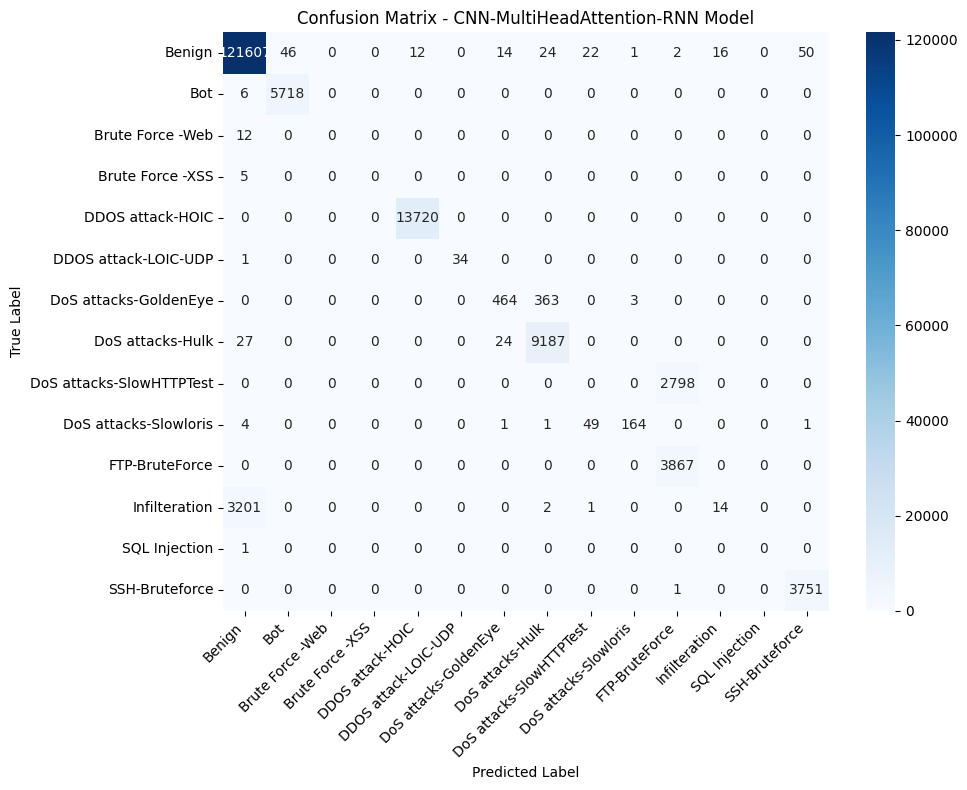

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, MultiHeadAttention, SimpleRNN, Input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the CNN-MultiHeadAttention-RNN model using Functional API
inputs = Input(shape=(X_train.shape[1], 1))  # Input shape: (timesteps, features)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)

# MultiHeadAttention requires query, value, and key. For self-attention, use the same tensor.
# Shape after MaxPooling1D: (timesteps//2, 64), which is compatible with MultiHeadAttention
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(query=x, value=x, key=x)

# SimpleRNN layer
rnn_output = SimpleRNN(64, return_sequences=True)(attention_output)

# Flatten and Dense layers
x = Flatten()(rnn_output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the model
cnn_mha_rnn_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
cnn_mha_rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
print("CNN-MultiHeadAttention-RNN Model Summary:")
cnn_mha_rnn_model.summary()

# Train the model
history = cnn_mha_rnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

# Evaluate the model
y_pred = cnn_mha_rnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Print evaluation metrics
print("\nCNN-MultiHeadAttention-RNN Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Confusion matrix with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN-MultiHeadAttention-RNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
cnn_mha_rnn_model.save('/content/drive/MyDrive/cnn_mha_rnn_model.h5')
print("Model saved successfully.")


Model saved successfully.


### **CNN + Bidirectional LSTM (BiLSTM)**

CNN-BiLSTM Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 76, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 38, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4864)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         311,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,574 (1.44 MB)

 Trainable params: 378,574 (1.44 MB)

 Non-trainable params: 0 (0.00 B)


Training CNN-BiLSTM Model...
Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 114s 11ms/step - accuracy: 0.8984 - loss: 0.3607 - val_accuracy: 0.9559 - val_loss: 0.1319
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - accuracy: 0.9504 - loss: 0.1569 - val_accuracy: 0.9593 - val_loss: 0.1200
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 142s 11ms/step - accuracy: 0.9555 - loss: 0.1417 - val_accuracy: 0.9634 - val_loss: 0.1197
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 113s 11ms/step - accuracy: 0.9569 - loss: 0.1372 - val_accuracy: 0.9613 - val_loss: 0.1162
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - accuracy: 0.9582 - loss: 0.1326 - val_accuracy: 0.9613 - val_loss: 0.1176
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - accuracy: 0.9582 - loss: 0.1307 - val_accuracy: 0.9585 - val_loss: 0.1184
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 132s 10ms/step - accuracy: 0.9588 - loss: 0.1279 - val_accuracy: 0.9618 - val_loss: 0.1138
Epoch 8/10
10326/10326 ━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN-BiLSTM Model Evaluation:
Accuracy: 0.9613
Precision: 0.9594
Recall: 0.9613
F1-Score: 0.9517

Confusion Matrix:
[[121528     26      0      0      2      0     12     22     24      0
       0    169      0     11]
 [     5   5719      0      0      0      0      0      0      0      0
       0      0      0      0]
 [    12      0      0      0      0      0      0      0      0      0
       0      0      0      0]
 [     5      0      0      0      0      0      0      0      0      0
       0      0      0      0]
 [     0      0      0      0  13720      0      0      0      0      0
       0      0      0      0]
 [     0      0      0      0      0     35      0      0      0      0
       0      0      0      0]
 [     1      0      0      0      0      0    462    366      0      1
       0      0      0      0]
 [     0      0      0      0      0      0      0   9238      0      0
       0      0      0      0]
 [     0      0      0      0      0      0      0      0   

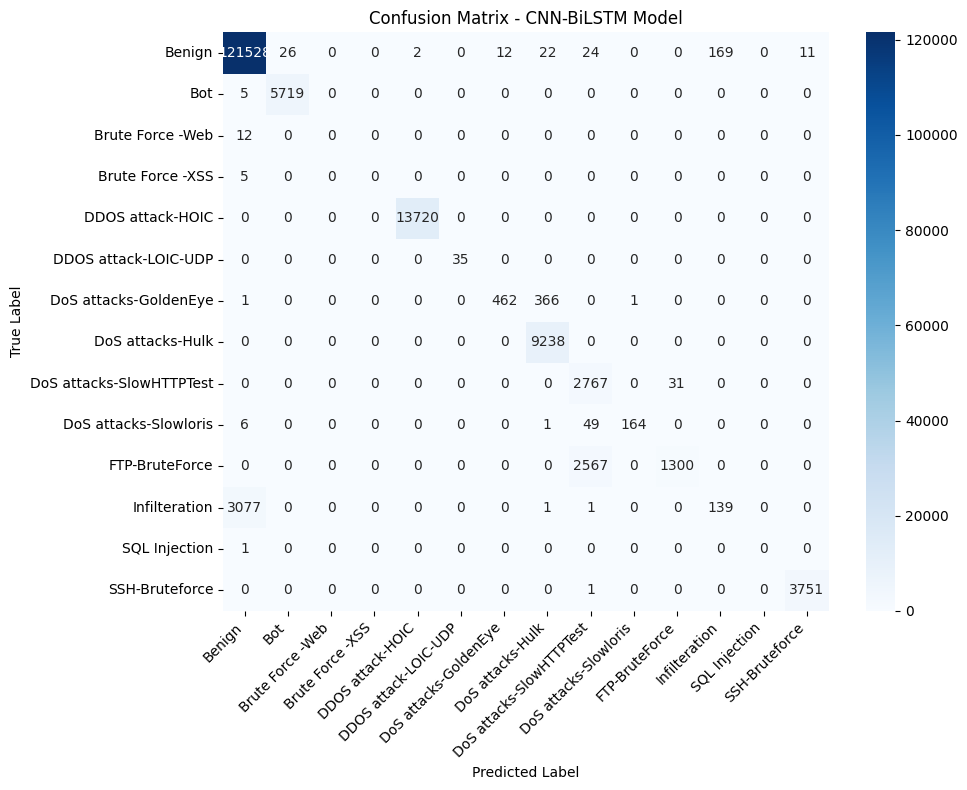

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the CNN-BiLSTM model
cnn_bilstm_model = Sequential()
cnn_bilstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_bilstm_model.add(MaxPooling1D(pool_size=2))
cnn_bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
cnn_bilstm_model.add(Flatten())
cnn_bilstm_model.add(Dense(64, activation='relu'))
cnn_bilstm_model.add(Dropout(0.5))
cnn_bilstm_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
cnn_bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
print("CNN-BiLSTM Model Summary:")
cnn_bilstm_model.summary()

# Train the model
print("\nTraining CNN-BiLSTM Model...")
history = cnn_bilstm_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

# Evaluate the model
y_pred = cnn_bilstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Print evaluation metrics
print("\nCNN-BiLSTM Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Confusion matrix with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN-BiLSTM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
cnn_bilstm_model.save('/content/drive/MyDrive/cnn_bilstm_model.h5')
print("Model saved successfully.")


Model saved successfully.


### **CNN + Dilated Convolution + GRU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten

# Define the CNN-Dilated-GRU model
cnn_dilated_gru_model = Sequential()
cnn_dilated_gru_model.add(Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu', input_shape=(X_train.shape[1], 1)))  # Dilated Conv
cnn_dilated_gru_model.add(MaxPooling1D(pool_size=2))
cnn_dilated_gru_model.add(GRU(64, return_sequences=True))
cnn_dilated_gru_model.add(Flatten())
cnn_dilated_gru_model.add(Dense(64, activation='relu'))
cnn_dilated_gru_model.add(Dropout(0.5))
cnn_dilated_gru_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
cnn_dilated_gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
print("CNN-Dilated-GRU Model Summary:")
cnn_dilated_gru_model.summary()

# Train the model
history = cnn_dilated_gru_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=1)

CNN-Dilated-GRU Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 74, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 37, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 37, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2368)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         151,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,742 (694.30 KB)

 Trainable params: 177,742 (694.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.9031 - loss: 0.3470 - val_accuracy: 0.9587 - val_loss: 0.1273
Epoch 2/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.9470 - loss: 0.1669 - val_accuracy: 0.9599 - val_loss: 0.1241
Epoch 3/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - accuracy: 0.9505 - loss: 0.1566 - val_accuracy: 0.9618 - val_loss: 0.1156
Epoch 4/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9525 - loss: 0.1515 - val_accuracy: 0.9653 - val_loss: 0.1150
Epoch 5/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.9537 - loss: 0.1495 - val_accuracy: 0.9606 - val_loss: 0.1156
Epoch 6/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9544 - loss: 0.1476 - val_accuracy: 0.9644 - val_loss: 0.1143
Epoch 7/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9550 - loss: 0.1478 - val_accuracy: 0.9654 - val_loss: 0.1124
Epoch 8/10
10326/10326 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 

In [ ]:
cnn_dilated_gru_model.save('/content/drive/MyDrive/cnn_dilated_gru_model.h5')
print("Model saved successfully.")


Model saved successfully.
